In [47]:
# Third-party imports,
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view

"""SPECIFICATIONS"""
SPEC = "IllustrisTNG_CV_z=0"
input_UNITS = r"$M_{\odot}/h/(Mpc/h)^3$"
target_UNITS = r"$(Mpc/h)^{-3}$"
input_QUANTITY = "Dark Matter Density"
target_QUANTITY = "Electron Number Density"

# Loading data files,
X = np.load(r"..//CAMELs//IllustrisTNG_CV_z=0//Grids_Mcdm_IllustrisTNG_CV_256_z=0.0.npy", mmap_mode='r')
Y = np.load(r"..//CAMELs//IllustrisTNG_CV_z=0//Grids_ne_IllustrisTNG_CV_256_z=0.0.npy", mmap_mode='r')

# Stage 1 - Scaling, Normalisation & Cube Creation

In [48]:
# Defining help functions, 

def sample_random_cubes(X, cube_size, N, seed=None):
    """
    Randomly samples N cubes of size (cube_size, cube_size, cube_size) 
    from a 3D array X along with their centers.
    
    Parameters:
        X (numpy.ndarray): Input 3D array of shape (256, 256, 256).
        cube_size (int): Size of the cube to extract (must be odd).
        N (int): Number of cubes to sample.
        seed (int, optional): Random seed for reproducibility.
    
    Returns:
        cubes (numpy.ndarray): Extracted cubes of shape (N, cube_size, cube_size, cube_size).
        centers (numpy.ndarray): Corresponding center coordinates of shape (N, 3).
    """
    if seed is not None:
        np.random.seed(seed)

    D, H, W = X.shape
    pad_size = cube_size // 2  # 15 for 31x31x31 cubes

    # Valid range for cube centers (to avoid out-of-bounds)
    valid_range = np.arange(pad_size, D - pad_size)

    # Sample N random centers
    center_coords = np.column_stack([
        np.random.choice(valid_range, N),  # Random D-coordinates
        np.random.choice(valid_range, N),  # Random H-coordinates
        np.random.choice(valid_range, N),  # Random W-coordinates
    ])

    # Extract cubes using advanced indexing
    cubes = np.zeros((N, cube_size, cube_size, cube_size), dtype=X.dtype)
    for i, (d, h, w) in enumerate(center_coords):
        cubes[i] = X[d - pad_size : d + pad_size + 1, 
                     h - pad_size : h + pad_size + 1, 
                     w - pad_size : w + pad_size + 1]

    return cubes, center_coords

def extract_cubes_with_centers(Y, centers, cube_size):
    
    """
    Extracts cubes of size (cube_size, cube_size, cube_size) from a 3D array Y 
    using precomputed center coordinates.
    
    Parameters:
        Y (numpy.ndarray): Input 3D array of shape (256, 256, 256).
        centers (numpy.ndarray): Array of shape (N, 3) with (d, h, w) centers.
        cube_size (int): Size of the cube to extract (must be odd).
    
    Returns:
        cubes (numpy.ndarray): Extracted cubes of shape (N, cube_size, cube_size, cube_size).
    """
    if Y.ndim != 3:
        raise ValueError(f"Expected a 3D array for Y, but got shape {Y.shape}")

    N = centers.shape[0]
    pad_size = cube_size // 2  # 4 for 9x9x9 cubes

    # Extract cubes
    cubes = np.zeros((N, cube_size, cube_size, cube_size), dtype=Y.dtype)
    for i, (d, h, w) in enumerate(centers):
        cubes[i] = Y[d - pad_size : d + pad_size + 1, 
                     h - pad_size : h + pad_size + 1, 
                     w - pad_size : w + pad_size + 1]
    
    return cubes

def MinMaxNorm(data, epsilon=1e-6):
    min_val = np.min(data, axis=(1, 2), keepdims=True)
    max_val = np.max(data, axis=(1, 2), keepdims=True)
    return (data - min_val)/(max_val - min_val)

"""Settings"""
X_CUBE_SIZE = 35
Y_CUBE_SIZE = 9
N = 2500
SEED = 43

# Only considering a single (or a few) 3D grids,
X, Y = X[0], Y[0]

# Applying logarithmic transform,
X, Y = np.log(X), np.log(Y)

# Applying Min-Max normalisation,
X, Y = MinMaxNorm(X), MinMaxNorm(Y)

# Saving simulation to .npy files,
np.save("X_sim.npy", X)
np.save("Y_sim.npy", Y)

# Extracting random cubes and their centre locations from X,
X_cubes, X_cube_centres = sample_random_cubes(X, X_CUBE_SIZE, N, SEED)

# Extracting the corresponding cubes from Y,
Y_cubes = extract_cubes_with_centers(Y, X_cube_centres, Y_CUBE_SIZE)

# Data Visualiser

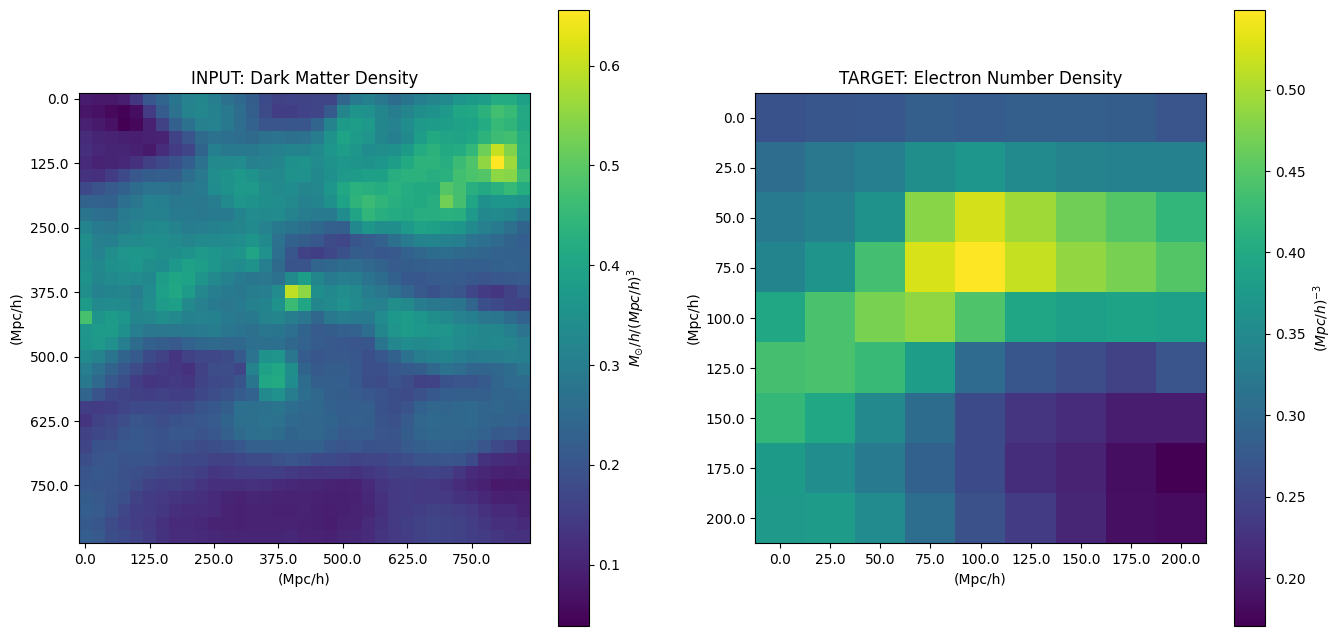

In [40]:
def plot_XYpair(image1, image2):
    """Plots the ith slice of the a 3D grid."""

    # Creating figure, axis and image,
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    img1 = axes[0].imshow(image1)
    img2 = axes[1].imshow(image2)

    # Setting labels,
    axes[0].set_xlabel("(Mpc/h)")
    axes[0].set_ylabel("(Mpc/h)")
    axes[0].set_title("INPUT: " + input_QUANTITY)

    axes[1].set_xlabel("(Mpc/h)")
    axes[1].set_ylabel("(Mpc/h)")
    axes[1].set_title("TARGET: " + target_QUANTITY)

    # Custom xtick and ytick labels,
    def custom_formatter(x, pos):
        return f'{x*25}'

    # Setting formatter,
    FORMATTER = FuncFormatter(custom_formatter)
    axes[0].xaxis.set_major_formatter(FORMATTER)
    axes[0].yaxis.set_major_formatter(FORMATTER)
    axes[1].xaxis.set_major_formatter(FORMATTER)
    axes[1].yaxis.set_major_formatter(FORMATTER)

    # Adding color bar,
    cbar1 = plt.colorbar(img1, ax=axes[0], orientation="vertical")
    cbar1.set_label(input_UNITS)
    cbar1 = plt.colorbar(img2, ax=axes[1], orientation="vertical")
    cbar1.set_label(target_UNITS)

    # Showing plot,
    plt.show()

"""VISUALISATION"""
i = 15
plot_XYpair(X_cubes[i][18], Y_cubes[i][4])

# Stage 2 - Training, Testing and Validation Split

In [41]:
# Defining the split,
TRAIN_PROP = 0.75
VALIDATION_PROP = 0.10
TEST_PROP = 0.15
RANDOM_STATE = 38

# Creating explicit indices,
data_length = X_cubes.shape[0]
data_indices = np.arange(start = 0, stop = data_length, step = 1)

# Shuffling the indices,
np.random.shuffle(data_indices)

# Split indices into train and temp (val+test),
train_indices, temp_indices = train_test_split(data_indices, test_size = (VALIDATION_PROP + TEST_PROP), random_state = RANDOM_STATE)

# Further split temp into validation and test,
val_indices, test_indices = train_test_split(temp_indices, test_size = (TEST_PROP/(VALIDATION_PROP + TEST_PROP)), random_state = RANDOM_STATE)

# Creating training, testing and validation data,
X_train, Y_train = X_cubes[train_indices], Y_cubes[train_indices]
X_test, Y_test = X_cubes[test_indices], Y_cubes[test_indices]
X_val, Y_val = X_cubes[val_indices], Y_cubes[val_indices]

# Stage 3 - Create TF Datasets

In [42]:
# Functions,
def serialise_example(x, y):
    """Serialises an (X,Y) pair for effficient storage."""
    feature = {
        "X_data": tf.train.Feature(float_list=tf.train.FloatList(value=x.flatten())),
        "Y_data": tf.train.Feature(float_list=tf.train.FloatList(value=y.flatten())),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def save_to_tfrecord(X, Y, filename):
    """Write the dataset to a file on the disk."""
    with tf.io.TFRecordWriter(filename) as writer:
        for i in range(len(X)):
            example = serialise_example(X[i], Y[i])
            writer.write(example)
    print(f"Saved: {filename}")

def add_channel(array):
    """Adds an additonal dimension for the image channel."""
    return np.expand_dims(array, axis = -1)

# Adding channel dimension (TF uses channel first scheme),
X_train, Y_train = add_channel(X_train), add_channel(Y_train)
X_test, Y_test = add_channel(X_test), add_channel(Y_test)
X_val, Y_val = add_channel(X_val), add_channel(Y_val)

# Saving to dataset to record files,
save_to_tfrecord(X_train, Y_train, "training_dataset.tfrecord")
save_to_tfrecord(X_test, Y_test, "testing_dataset.tfrecord")
save_to_tfrecord(X_val, Y_val, "validation_dataset.tfrecord")

Saved: training_dataset.tfrecord
Saved: testing_dataset.tfrecord
Saved: validation_dataset.tfrecord
